In [2]:
# block 1: import all important libraries


%matplotlib inline
from netCDF4 import Dataset
from netCDF4 import num2date
from matplotlib.pyplot import figure, pcolor, colorbar, xlabel, ylabel, title, draw, quiver, show
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
import pandas as pd
import numpy as np
import numpy.ma as ma
from math import sqrt 

In [3]:
# block 2: Import the used data file and create a variable with the data in the file

data = "http://thredds.aodn.org.au/thredds/dodsC/IMOS/ABOS/DA/EAC1/Velocity/IMOS_ABOS-DA_AETVZ_20120421T130000Z_EAC1_FV01_EAC1-2012-WORKHORSE-ADCP-422_END-20130823T213855Z_C-20141016T011230Z.nc"
ADCPeac1 = Dataset(data) 

In [4]:
# block 3: Extracting the U/V/lat/long/time/H_B_S/qc data from the import file and assigns them to a variable

#basic data
LATeac1 = ADCPeac1.variables['LATITUDE']
LONeac1 = ADCPeac1.variables['LONGITUDE']
TIMESeac1 = ADCPeac1.variables['TIME']
DEPTHeac1 = ADCPeac1.variables['DEPTH']
Veac1 = ADCPeac1.variables['VCUR']
Ueac1 = ADCPeac1.variables['UCUR']
Weac1 = ADCPeac1.variables['WCUR']
Wheighteac1 = ADCPeac1.variables['HEIGHT_ABOVE_SENSOR']

#quality control
hasqc = ADCPeac1.variables['HEIGHT_ABOVE_SENSOR_quality_control']
Vqc = ADCPeac1.variables['VCUR_quality_control']
Uqc = ADCPeac1.variables['UCUR_quality_control']
Dqc = ADCPeac1.variables['DEPTH_quality_control']
tqc = ADCPeac1.variables['TIME_quality_control']

In [5]:
#block 4: Convert the ADCP time serie dataset (Matlab to python time serie: yyyy/mm/dd hh/mm/ss)

unitseac1 = ADCPeac1.variables['TIME'].units
calendareac1 = ADCPeac1.variables['TIME'].calendar
timeseac1  = num2date(ADCPeac1.variables['TIME'][:], units=unitseac1, calendar=calendareac1)

In [6]:
#block 5: Creat variable with ADCP dataset 

#For the basic data
latData =  LATeac1[:]   
lonData = LONeac1[:]       
W2 = Weac1 [:,:,:,:]
Wcolumn = Wheighteac1[:]   
data_u = Ueac1 [:,:,:,:]
data_v = Veac1 [:,:,:,:]
dph = DEPTHeac1[:,0,0]
v2d = data_v[:,:,0,0]
u2d = data_u[:,:,0,0]

#For the quality controle data 
hasqc1 = hasqc[:]
Vqc1 = Vqc[:,:,0,0]
Uqc1 = Uqc[:,:,0,0]
Dqc1 = Dqc[:,0,0]

In [7]:
#block 6: Mask the wrong values and creat a new variable with the good values.
hasqc2 = ma.masked_where (hasqc1 != 4, Wcolumn)
Dqc2 = ma.masked_where (Dqc1 != 1, dph)
Vqc2 = ma.masked_where (Vqc1 != 1,v2d)
Uqc2 = ma.masked_where (Uqc1 != 1,u2d )

In [8]:
#block 7: reshape the depth of the mooring(dph) and the depth above the sensor(Wcolumn) for have the same shape.

dph14=np.kron(np.ones((30,1)),Dqc2) # repeated the dph 14 times to match size of v2d.
dph14f = ma.masked_where (dph14 < 0,dph14)
Wtime=np.kron(np.ones((11886,1)),hasqc2)

In [9]:
#block 8: Creation of the real depth variable.

DepthReal = dph14f-Wtime.T

In [10]:
#block 9: Creat the mean Speed/Power variable with U and V.

Speed = (Uqc2*Uqc2) + (Vqc2*Vqc2)
Speedf = np.sqrt(Speed)
P = 0.5 * 1025 * 4 * (Speedf*Speedf*Speedf)     
Pf = P/1000

/home/z3525831/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [18]:
#block 10: Creat the good Time and depth variable for the scatter plot.

times1 = ADCPeac1.variables['TIME'][:]
times2 = np.resize(times1,(1,11886))
Tfinal = np.kron(np.ones((30,1)),times2)
Tfinal2 = np.resize(times1,((11886, 30)))
DepthReal2 = ma.masked_where (DepthReal < 0,DepthReal)

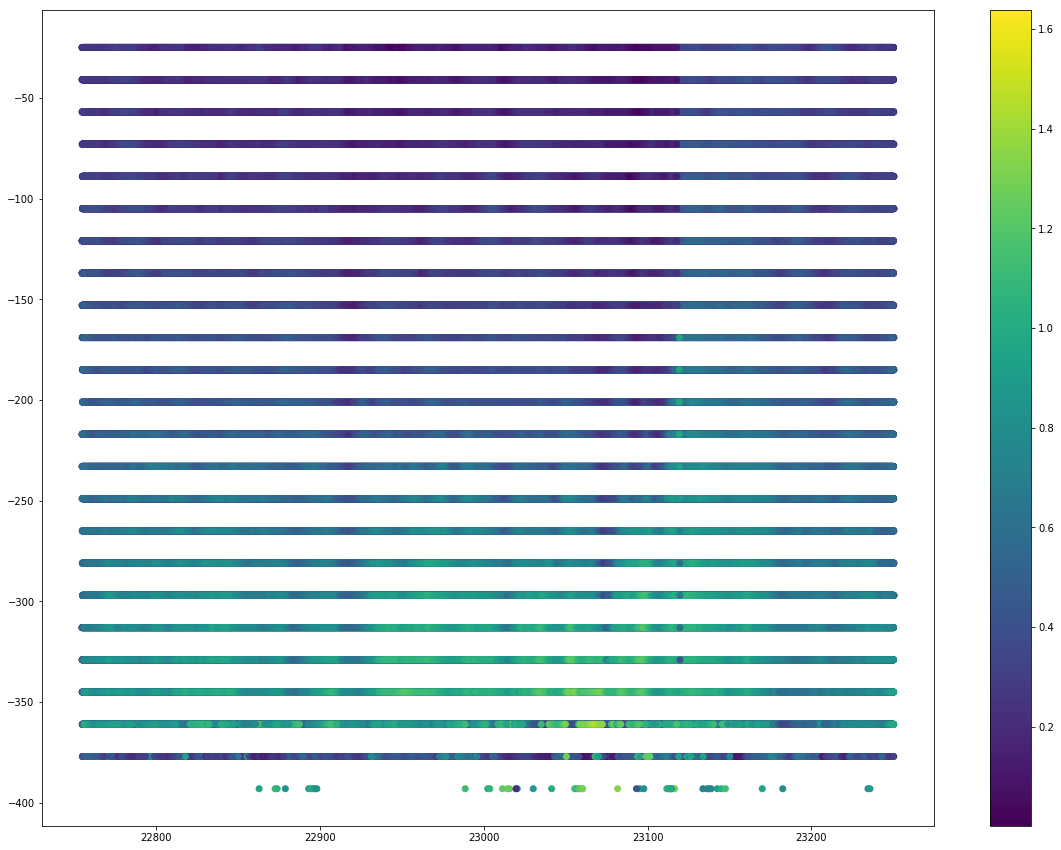

In [19]:
#block 11: Plot the Speed according to the time

plt.figure(figsize=(20,15))
plt.scatter(Tfinal2, -Wtime , c= Speedf)
plt.colorbar()
plt.show()

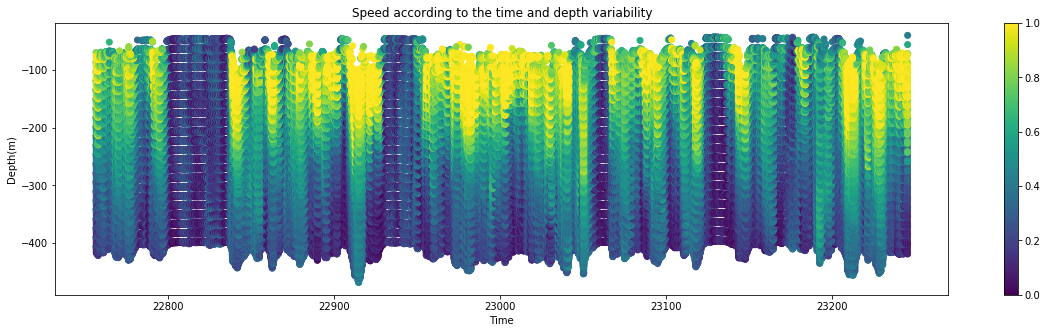

In [21]:
#block 12: Plot the Speed according to the time and depth variability. 
    
plt.figure(figsize=(20,5))
plt.scatter(Tfinal2,-DepthReal2 , c=Speedf.T ,vmin=0,vmax=1) 
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Speed according to the time and depth variability")
plt.colorbar()
plt.show()

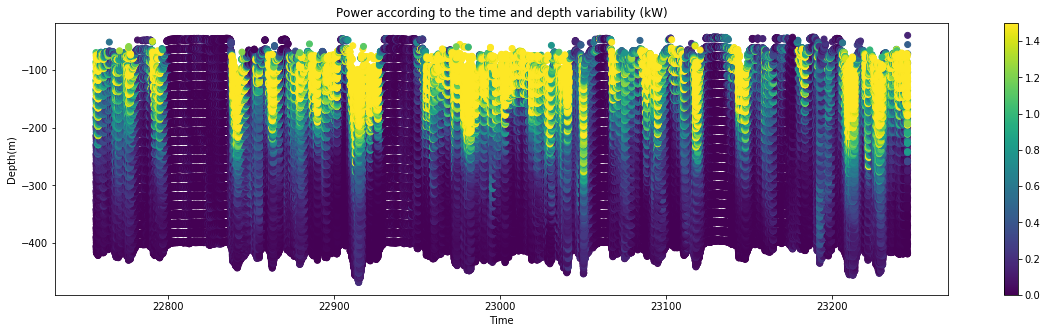

In [22]:
#block 13: Plot the Power according to the time and depth variability.

plt.figure(figsize=(20,5))
plt.scatter(Tfinal2,-DepthReal2 , c= Pf.T, vmin=0,vmax=1.50)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Power according to the time and depth variability (kW)")
plt.colorbar()
plt.show()